# QML Class Spring 2024 - Project

**Kotsias Ioannis**

**1115202000113**

## Project Overview

This project involves simulating a quantum classifier using a variational quantum circuit for classifying data for the binary classification parity problem with 3 and 5 inputs. The project is divided into three parts:

1. **Simulate a quantum classifier for the 3-input parity problem (6/10 credits)**
2. **Compare different classical optimization methods (2/10)**
3. **Extend the model to the 5-input parity problem (2/10)**

## Part 1: Quantum Classifier for 3-input Parity Problem


###Install dependancies, mount drive and import packages

In [27]:
!pip install pennylane

from google.colab import drive
drive.mount('/content/drive')

import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer, NesterovMomentumOptimizer, AdagradOptimizer
import matplotlib.pyplot as plt

# Load the data from Google Drive
base_path = '/content/drive/MyDrive/QML/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and Preprocess Data
First, I will load the training and test data for the 3-input parity problem and preprocess it.

In [28]:
classA_train = np.loadtxt(base_path + "classA_train.dat")
classB_train = np.loadtxt(base_path + "classB_train.dat")
classA_test = np.loadtxt(base_path + "classA_test.dat")
classB_test = np.loadtxt(base_path + "classB_test.dat")

# Preprocess the data
def preprocess_data(classA, classB):
    X = np.vstack((classA, classB))
    y = np.hstack((np.ones(len(classA)), -1*np.ones(len(classB))))
    X -= 0.5
    return X, y

X_train, y_train = preprocess_data(classA_train, classB_train)
X_test, y_test = preprocess_data(classA_test, classB_test)

### Design of the Quantum Circuit

I design a variational quantum circuit using up to 4 qubits, which includes layers of parameterized rotation gates and entangling CNOT gates. The state preparation step re-uploads the data into the circuit.

In [29]:
# Initialize device
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

# Define a layer of the variational quantum circuit
def layer(weights):
    for i in range(num_qubits):
        qml.Rot(*weights[i], wires=i)
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i+1) % num_qubits])

# Data re-uploading in state preparation
def state_preparation(x):
    for i in range(num_qubits):
        qml.RX(x[i % len(x)], wires=i)


### Define the Quantum Circuit and Classifier
I define the quantum circuit and the variational classifier function.

In [30]:
@qml.qnode(dev, interface='autograd')
def circuit(weights, x):
    state_preparation(x)
    for w in weights:
        layer(w)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


### Cost Function and Accuracy
Next, I define the cost function using the expectation value of measurements at the end of the circuit and the accuracy function.

In [31]:
def square_loss(labels, predictions):
    return qml.numpy.mean((labels - predictions) ** 2)

def accuracy(labels, predictions):
    return qml.numpy.mean(labels == qml.numpy.sign(predictions))

def cost(weights, bias, X, Y):
    predictions = qml.numpy.array([variational_classifier(weights, bias, x) for x in X])
    return square_loss(Y, predictions)


### Training the Quantum Classifier
I initialize the weights and bias and train the classifier using the Nesterov Momentum Optimizer. I also track and plot the cost over iterations.

Iteration: 10 | Cost: 1.0192 | Training Accuracy: 0.5000
Iteration: 20 | Cost: 0.9915 | Training Accuracy: 0.5000
Iteration: 30 | Cost: 0.9437 | Training Accuracy: 0.5000
Iteration: 40 | Cost: 0.8349 | Training Accuracy: 0.8000
Iteration: 50 | Cost: 0.8909 | Training Accuracy: 0.7000
Iteration: 60 | Cost: 0.8231 | Training Accuracy: 0.7750
Iteration: 70 | Cost: 0.7497 | Training Accuracy: 0.8250
Iteration: 80 | Cost: 0.7605 | Training Accuracy: 0.7000
Iteration: 90 | Cost: 0.7401 | Training Accuracy: 0.7750
Iteration: 100 | Cost: 0.7206 | Training Accuracy: 1.0000
Test Accuracy: 1.0000


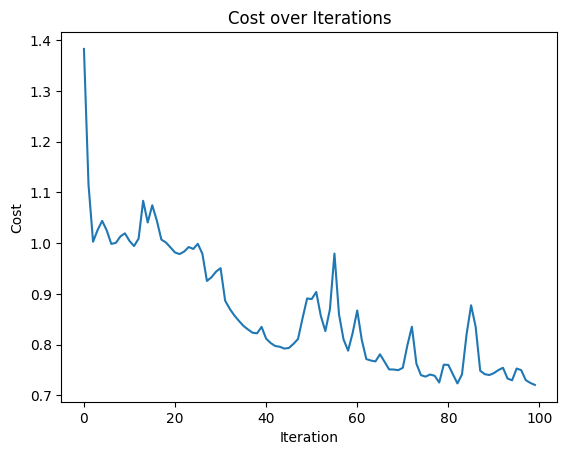

In [32]:
np.random.seed(0)
num_layers = 4
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
weights_init = qml.numpy.array(weights_init, requires_grad=True)
bias_init = qml.numpy.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.1)
batch_size = 10
num_iterations = 100

weights = weights_init
bias = bias_init

costs = []

for it in range(num_iterations):
    # Random batch sampling
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    weights, bias = opt.step(cost, weights, bias, X=qml.numpy.array(X_batch), Y=qml.numpy.array(Y_batch))

    # Accuracy and cost on the training set
    predictions = [variational_classifier(weights, bias, x) for x in X_train]
    acc_train = accuracy(y_train, qml.numpy.sign(predictions))
    cost_train = cost(weights, bias, X_train, y_train)
    costs.append(cost_train)

    if (it + 1) % 10 == 0:
        print(f"Iteration: {it + 1} | Cost: {cost_train:.4f} | Training Accuracy: {acc_train:.4f}")

# Evaluation on the test set
predictions_test = [variational_classifier(weights, bias, x) for x in X_test]
acc_test = accuracy(y_test, qml.numpy.sign(predictions_test))

print(f"Test Accuracy: {acc_test:.4f}")

# Plotting the cost over iterations
plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations")
plt.show()


###Circuit Visualization
I visualize the designed quantum circuit to better understand its structure.

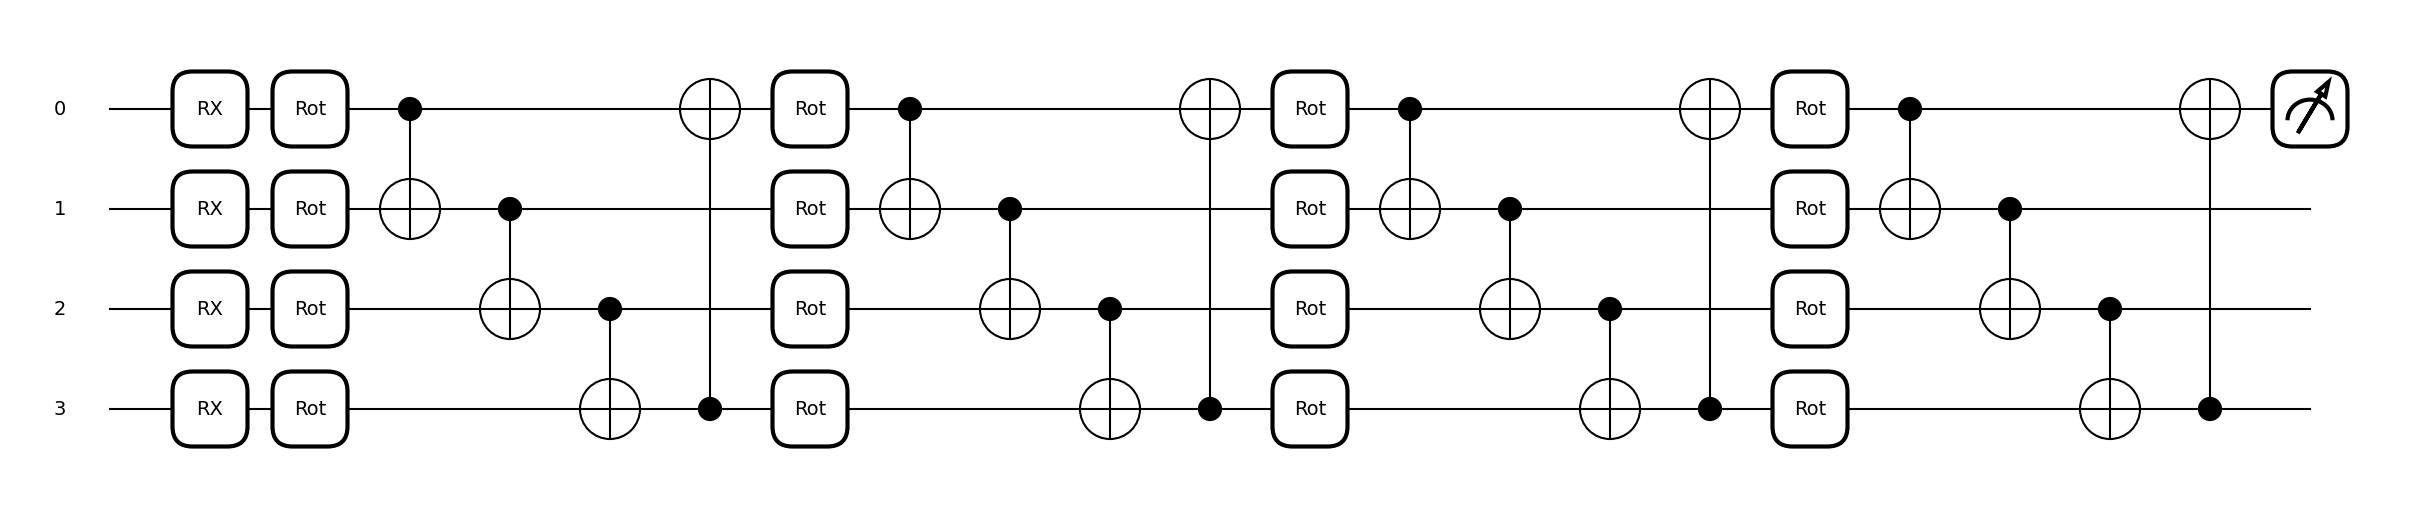

In [33]:
num_qubits = 4
num_layers = 4
dev = qml.device("default.qubit", wires=num_qubits)

# Define the circuit for plotting
def layer(weights):
    for i in range(num_qubits):
        qml.Rot(*weights[i], wires=i)
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i + 1) % num_qubits])

def state_preparation(x):
    for i in range(num_qubits):
        qml.RX(x[i % len(x)], wires=i)

@qml.qnode(dev)
def circuit(weights, x=None):
    state_preparation([0] * num_qubits)  # Dummy input for plotting
    for w in weights:
        layer(w)
    return qml.expval(qml.PauliZ(0))

# Dummy weights for visualization
weights = np.random.randn(num_layers, num_qubits, 3)

# Visualize the circuit using matplotlib
fig, ax = qml.draw_mpl(circuit)(weights=weights)
plt.show()


##Part 2: Comparison of Classical Optimization Methods

###Comparison of Classical Optimization Methods
I compare the performance of different classical optimization methods: Nesterov Momentum Optimizer, Adam Optimizer, and Adagrad Optimizer.

NesterovMomentum - Iteration: 10 | Cost: 1.0192 | Training Accuracy: 0.5000
NesterovMomentum - Iteration: 20 | Cost: 0.9915 | Training Accuracy: 0.5000
NesterovMomentum - Iteration: 30 | Cost: 0.9437 | Training Accuracy: 0.5000
NesterovMomentum - Iteration: 40 | Cost: 0.8349 | Training Accuracy: 0.8000
NesterovMomentum - Iteration: 50 | Cost: 0.8909 | Training Accuracy: 0.7000
NesterovMomentum - Iteration: 60 | Cost: 0.8231 | Training Accuracy: 0.7750
NesterovMomentum - Iteration: 70 | Cost: 0.7497 | Training Accuracy: 0.8250
NesterovMomentum - Iteration: 80 | Cost: 0.7605 | Training Accuracy: 0.7000
NesterovMomentum - Iteration: 90 | Cost: 0.7401 | Training Accuracy: 0.7750
NesterovMomentum - Iteration: 100 | Cost: 0.7206 | Training Accuracy: 1.0000
Adam - Iteration: 10 | Cost: 0.9112 | Training Accuracy: 0.6000
Adam - Iteration: 20 | Cost: 0.9310 | Training Accuracy: 0.7750
Adam - Iteration: 30 | Cost: 0.9089 | Training Accuracy: 0.4000
Adam - Iteration: 40 | Cost: 0.8778 | Training 

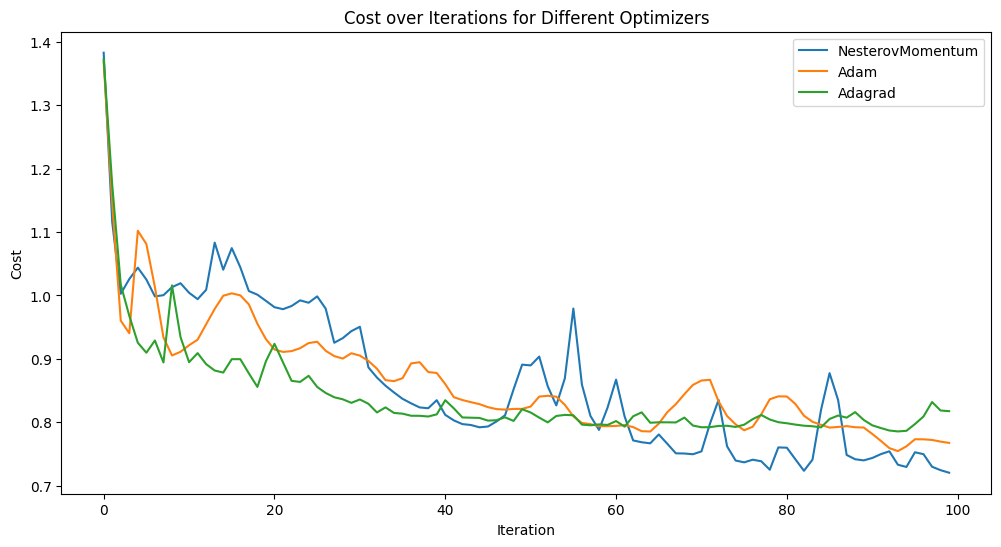

NesterovMomentum - Training Accuracy: 1.0000, Test Accuracy: 1.0000
Adam - Training Accuracy: 0.7750, Test Accuracy: 0.6500
Adagrad - Training Accuracy: 0.7000, Test Accuracy: 0.6000


In [34]:
# Preprocess the data
def preprocess_data(classA, classB):
    X = np.vstack((classA, classB))
    y = np.hstack((np.ones(len(classA)), -1*np.ones(len(classB))))
    X -= 0.5
    return X, y

X_train, y_train = preprocess_data(classA_train, classB_train)
X_test, y_test = preprocess_data(classA_test, classB_test)

# Initialize device
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

# Define a layer of the variational quantum circuit
def layer(weights):
    for i in range(num_qubits):
        qml.Rot(*weights[i], wires=i)
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i+1) % num_qubits])

# Data re-uploading in state preparation
def state_preparation(x):
    for i in range(num_qubits):
        qml.RX(x[i % len(x)], wires=i)

@qml.qnode(dev, interface='autograd')
def circuit(weights, x):
    state_preparation(x)
    for w in weights:
        layer(w)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    return qml.numpy.mean((labels - predictions) ** 2)

def accuracy(labels, predictions):
    return qml.numpy.mean(labels == qml.numpy.sign(predictions))

def cost(weights, bias, X, Y):
    predictions = qml.numpy.array([variational_classifier(weights, bias, x) for x in X])
    return square_loss(Y, predictions)

np.random.seed(0)
num_layers = 4
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
weights_init = qml.numpy.array(weights_init, requires_grad=True)
bias_init = qml.numpy.array(0.0, requires_grad=True)

# Optimizers to compare
optimizers = {
    "NesterovMomentum": NesterovMomentumOptimizer(0.1),
    "Adam": AdamOptimizer(0.1),
    "Adagrad": AdagradOptimizer(0.1)
}

batch_size = 10
num_iterations = 100

results = {}

for opt_name, opt in optimizers.items():
    weights = weights_init
    bias = bias_init
    costs = []

    for it in range(num_iterations):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = X_train[batch_index]
        Y_batch = y_train[batch_index]

        weights, bias = opt.step(cost, weights, bias, X=qml.numpy.array(X_batch), Y=qml.numpy.array(Y_batch))

        predictions = [variational_classifier(weights, bias, x) for x in X_train]
        acc_train = accuracy(y_train, qml.numpy.sign(predictions))
        cost_train = cost(weights, bias, X_train, y_train)
        costs.append(cost_train)

        if (it + 1) % 10 == 0:
            print(f"{opt_name} - Iteration: {it + 1} | Cost: {cost_train:.4f} | Training Accuracy: {acc_train:.4f}")

    predictions_test = [variational_classifier(weights, bias, x) for x in X_test]
    acc_test = accuracy(y_test, qml.numpy.sign(predictions_test))

    results[opt_name] = {
        "costs": costs,
        "acc_train": acc_train,
        "acc_test": acc_test
    }

# Plotting the cost over iterations for each optimizer
plt.figure(figsize=(12, 6))
for opt_name, result in results.items():
    plt.plot(result["costs"], label=opt_name)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations for Different Optimizers")
plt.legend()
plt.show()

# Print final accuracies for comparison
for opt_name, result in results.items():
    print(f"{opt_name} - Training Accuracy: {result['acc_train']:.4f}, Test Accuracy: {result['acc_test']:.4f}")



##Part 3: Extend the Model to 5-input Parity Problem
I extend the variational quantum classifier to classify data from the parity problem with 5 inputs. I use the Adam optimizer and compare the results.

Iteration: 10 | Cost: 1.0432 | Training Accuracy: 0.5000
Iteration: 20 | Cost: 1.0120 | Training Accuracy: 0.4750
Iteration: 30 | Cost: 0.9923 | Training Accuracy: 0.5250
Iteration: 40 | Cost: 0.9829 | Training Accuracy: 0.5875
Iteration: 50 | Cost: 0.9762 | Training Accuracy: 0.5687
Iteration: 60 | Cost: 0.9505 | Training Accuracy: 0.5563
Iteration: 70 | Cost: 0.8983 | Training Accuracy: 0.6062
Iteration: 80 | Cost: 0.8527 | Training Accuracy: 0.6188
Iteration: 90 | Cost: 0.7532 | Training Accuracy: 0.7438
Iteration: 100 | Cost: 0.6495 | Training Accuracy: 0.8875
Iteration: 110 | Cost: 0.5443 | Training Accuracy: 1.0000
Test Accuracy: 1.0000


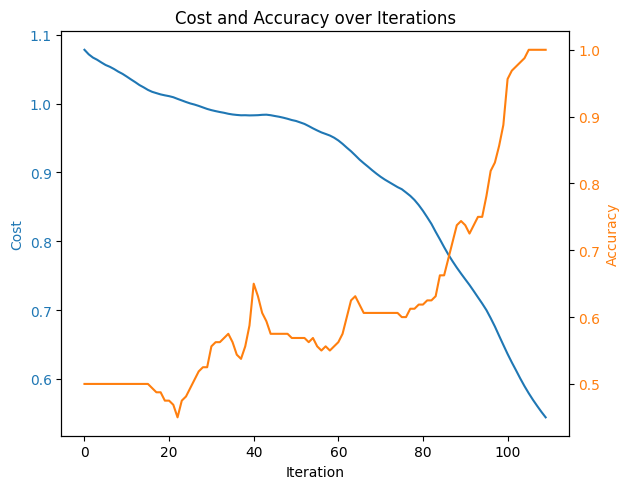

In [35]:
# Load the data
classA_train = np.loadtxt(base_path + "classA_train_N5.dat")
classB_train = np.loadtxt(base_path + "classB_train_N5.dat")
classA_test = np.loadtxt(base_path + "classA_test_N5.dat")
classB_test = np.loadtxt(base_path + "classB_test_N5.dat")

# Preprocess the data
def preprocess_data(classA, classB):
    X = np.vstack((classA, classB))
    y = np.hstack((np.ones(len(classA)), -1*np.ones(len(classB))))
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # Normalize
    return X, y

X_train, y_train = preprocess_data(classA_train, classB_train)
X_test, y_test = preprocess_data(classA_test, classB_test)

# Initialize device
num_qubits = 5
dev = qml.device("default.qubit", wires=num_qubits)

# Define a layer of the variational quantum circuit
def layer(weights):
    for i in range(num_qubits):
        qml.Rot(*weights[i], wires=i)
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i+1) % num_qubits])

# Data re-uploading in state preparation
def state_preparation(x):
    for i in range(num_qubits):
        qml.RX(x[i % len(x)], wires=i)

@qml.qnode(dev, interface='autograd')
def circuit(weights, x):
    state_preparation(x)
    for w in weights:
        layer(w)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    return qml.numpy.mean((labels - predictions) ** 2)

def accuracy(labels, predictions):
    return qml.numpy.mean(labels == qml.numpy.sign(predictions))

def cost(weights, bias, X, Y):
    predictions = qml.numpy.array([variational_classifier(weights, bias, x) for x in X])
    return square_loss(Y, predictions)

np.random.seed(0)
num_layers = 6  # Increased number of layers
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
weights_init = qml.numpy.array(weights_init, requires_grad=True)
bias_init = qml.numpy.array(0.0, requires_grad=True)

opt = AdamOptimizer(0.01)  # Using Adam optimizer with a learning rate of 0.01
batch_size = 10
num_iterations = 110

weights = weights_init
bias = bias_init

costs = []
accuracies = []

for it in range(num_iterations):
    # Random batch sampling
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = y_train[batch_index]

    weights, bias = opt.step(cost, weights, bias, X=qml.numpy.array(X_batch), Y=qml.numpy.array(Y_batch))

    # Accuracy and cost on the training set
    predictions = [variational_classifier(weights, bias, x) for x in X_train]
    acc_train = accuracy(y_train, qml.numpy.sign(predictions))
    cost_train = cost(weights, bias, X_train, y_train)
    costs.append(cost_train)
    accuracies.append(acc_train)

    if (it + 1) % 10 == 0:
        print(f"Iteration: {it + 1} | Cost: {cost_train:.4f} | Training Accuracy: {acc_train:.4f}")

# Evaluation on the test set
predictions_test = [variational_classifier(weights, bias, x) for x in X_test]
acc_test = accuracy(y_test, qml.numpy.sign(predictions_test))

print(f"Test Accuracy: {acc_test:.4f}")

# Plotting the cost and accuracy over iterations
fig, ax1 = plt.subplots()

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Cost", color="tab:blue")
ax1.plot(costs, color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:orange")
ax2.plot(accuracies, color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()
plt.title("Cost and Accuracy over Iterations")
plt.show()
